If you're dealing with a classification problem, you should use SVC in scikit-learn for building your Support Vector Machine model. Here's a step-by-step guide:

# SVM (support vector machine)

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('09people_FEAUTURES.csv')
df_TESTE = pd.read_csv('09people_FEAUTURES_TEST.csv')
df.head()

,Appetite,StSpirit,pEffort,uaI,uaI(-1),Sex_F,SleepInd,SleepInd(-1),pEffort(-1),pEffort(-2),Appetite(-1),Appetite(-2),FatigInd
0,6.0,5.0,8.0,2.00,2.00,1,-5.0,-6.0,7.0,6.0,6.0,6.0,Optimal
1,6.0,6.0,5.0,1.69,2.02,1,-3.5,-4.5,5.0,5.0,6.0,6.0,Optimal
2,6.0,6.0,5.0,1.94,1.87,1,-4.0,-5.0,5.0,5.0,6.0,6.0,Optimal
3,6.0,3.0,7.0,1.75,2.37,1,-5.0,-3.5,8.0,6.0,6.0,6.0,Optimal
4,6.0,5.0,5.0,2.52,1.85,1,-4.0,-4.0,6.0,5.0,6.0,6.0,Optimal


In [10]:
X = df.drop(columns=["FatigInd"])
y_train = df["FatigInd"]

X_test = df_TESTE.drop(columns=["FatigInd"])
y_test = df_TESTE["FatigInd"]

# standartizar os dados e separar treino de teste

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=34)
X_train.shape, X_test.shape

((528, 12), (117, 12))

## modelo base

The x value that maximizes kf is: 1.0999999999999999


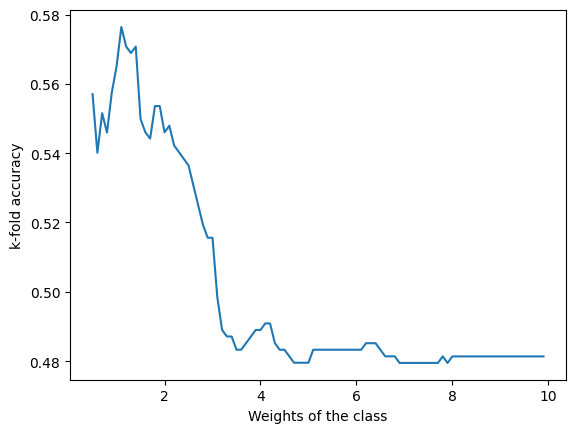

In [12]:
kf = []
weights = np.arange(0.5, 10, 0.1)
for wOP in weights:
    class_weights = {"Low/Minimal": 1, "Optimal": wOP, 'Risk/Caution': 1}  # Increase weight for Class 2
    svc = SVC(class_weight=class_weights)
    scores = cross_val_score(svc, X_train, y_train, cv=7, scoring='accuracy')
    kf.append(scores.mean())
plt.plot(weights, kf)
plt.xlabel('Weights of the class')
plt.ylabel('k-fold accuracy')

max_index = np.argmax(kf)

# Find the corresponding x value
x_max = weights[max_index]

print("The x value that maximizes kf is:", x_max)

In [13]:
# Define parameter distribution
param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter (log scale)
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Include sigmoid kernel
    'degree': [2, 3, 4],  # Degree for polynomial kernel (only useful for 'poly')
    'coef0': [0.0, 0.1, 0.5, 1.0, 2.0],  # Independent term in kernel
}

# Initialize the SVC model
class_weights = {"Low/Minimal": 1, "Optimal": 1, 'Risk/Caution': 1}  # Increase weight for Class 2
svc = SVC(class_weight=class_weights)

#svc = SVC()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                                   n_iter=500, cv=7, scoring='accuracy', 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'kernel': 'poly', 'gamma': 0.1, 'degree': 4, 'coef0': 2.0, 'C': np.float64(0.01)}


/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
best_svc = random_search.best_estimator_
best_svc.fit(X_train, y_train)

SVC(C=np.float64(0.01),
    class_weight={'Low/Minimal': 1, 'Optimal': 1, 'Risk/Caution': 1}, coef0=2.0,
    degree=4, gamma=0.1, kernel='poly')

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
14 fits failed out of a total of 35.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/svm/_base.py", line 199, in fit
    y = self._validate_targets(y)
  Fi

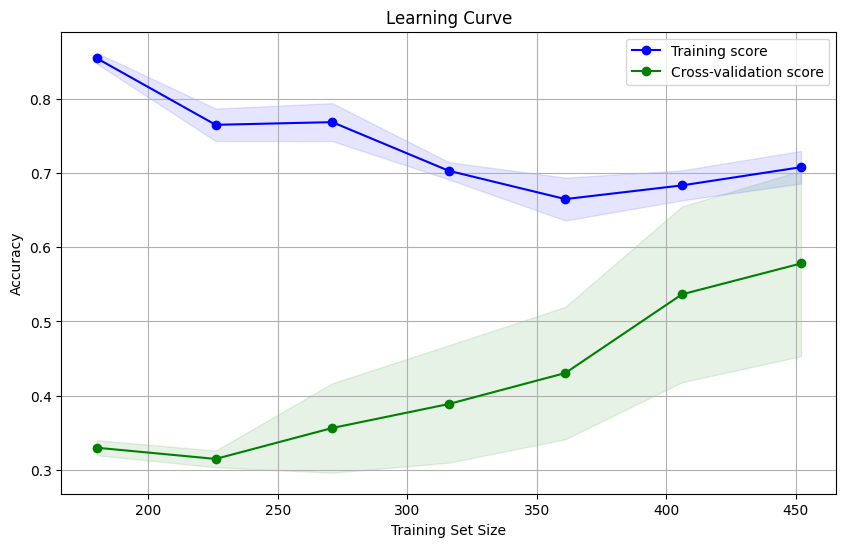

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    best_svc, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1
)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svc, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()



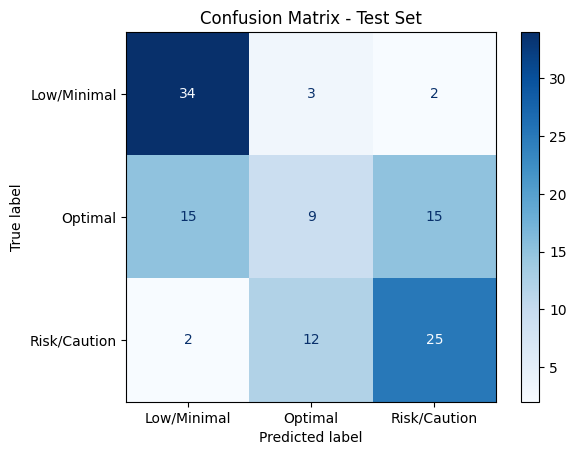

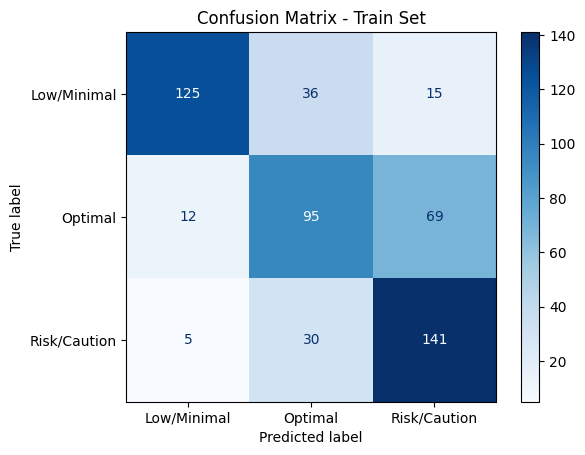

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred_test = best_svc.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_svc.classes_)
disp_test.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_svc.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_svc.classes_)
disp_train.plot(cmap="Blues")
plt.title("Confusion Matrix - Train Set")
plt.show()


In [17]:
from sklearn.metrics import classification_report

y_pred_test = best_svc.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.67      0.87      0.76        39
     Optimal       0.38      0.23      0.29        39
Risk/Caution       0.60      0.64      0.62        39

    accuracy                           0.58       117
   macro avg       0.55      0.58      0.55       117
weighted avg       0.55      0.58      0.55       117



In [18]:
y_pred_train = best_svc.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.88      0.71      0.79       176
     Optimal       0.59      0.54      0.56       176
Risk/Caution       0.63      0.80      0.70       176

    accuracy                           0.68       528
   macro avg       0.70      0.68      0.68       528
weighted avg       0.70      0.68      0.68       528

